<a href="https://colab.research.google.com/github/Rishikumar7137/Unstop-Talent-Park-PS1/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", trainable=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/job_descriptions.csv'
df = pd.read_csv(file_path)
df.head()

,Job Id,Experience,Qualifications,Salary Range,location,Country,latitude,longitude,Work Type,Company Size,...,Contact,Job Title,Role,Job Portal,Job Description,Benefits,skills,Responsibilities,Company,Company Profile
0,1089843540111562,5 to 15 Years,M.Tech,$59K-$99K,Douglas,Isle of Man,54.2361,-4.5481,Intern,26801,...,001-381-930-7517x737,Digital Marketing Specialist,Social Media Manager,Snagajob,Social Media Managers oversee an organizations...,"{'Flexible Spending Accounts (FSAs), Relocatio...","Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",Icahn Enterprises,"{""Sector"":""Diversified"",""Industry"":""Diversifie..."
1,398454096642776,2 to 12 Years,BCA,$56K-$116K,Ashgabat,Turkmenistan,38.9697,59.5563,Intern,100340,...,461-509-4216,Web Developer,Frontend Web Developer,Idealist,Frontend Web Developers design and implement u...,"{'Health Insurance, Retirement Plans, Paid Tim...","HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",PNC Financial Services Group,"{""Sector"":""Financial Services"",""Industry"":""Com..."
2,481640072963533,0 to 12 Years,PhD,$61K-$104K,Macao,"Macao SAR, China",22.1987,113.5439,Temporary,84525,...,9687619505,Operations Manager,Quality Control Manager,Jobs2Careers,Quality Control Managers establish and enforce...,"{'Legal Assistance, Bonuses and Incentive Prog...",Quality control processes and methodologies St...,Establish and enforce quality control standard...,United Services Automobile Assn.,"{""Sector"":""Insurance"",""Industry"":""Insurance: P..."
3,688192671473044,4 to 11 Years,PhD,$65K-$91K,Porto-Novo,Benin,9.3077,2.3158,Full-Time,129896,...,+1-820-643-5431x47576,Network Engineer,Wireless Network Engineer,FlexJobs,"Wireless Network Engineers design, implement, ...","{'Transportation Benefits, Professional Develo...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",Hess,"{""Sector"":""Energy"",""Industry"":""Mining, Crude-O..."
4,117057806156508,1 to 12 Years,MBA,$64K-$87K,Santiago,Chile,-35.6751,-71.5429,Intern,53944,...,343.975.4702x9340,Event Manager,Conference Manager,Jobs2Careers,A Conference Manager coordinates and manages c...,"{'Flexible Spending Accounts (FSAs), Relocatio...",Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,Cairn Energy,"{""Sector"":""Energy"",""Industry"":""Energy - Oil & ..."


In [4]:
tmp = df

unused_columns = ['Job Id', 'Company Size', 'latitude', 'longitude', 'Contact', 'Job Portal', 'Benefits' , 'Company' , 	'Company Profile', 'Job Posting Date', 'Contact Person']

df.drop(columns=unused_columns, inplace=True)

In [9]:
def categorise_experience(df):
  df['Min Experience'] = df['Experience'].apply(lambda x: 'Freshers' if x[0] == '0' else
                                        '1 Years' if x[0:2] == '1 ' else
                                        '2 years' if x[0:2] == '2 ' else
                                        '3 years' if x[0:2] == '3 ' else
                                        '4 years' if x[0:2] == '4 ' else
                                        '5 years +' if (x[0:2] >= '5 ' and x[1] == ' ') else
                                        '10 years +')
  return df
df = categorise_experience(df)


df.drop(columns=['Experience'], inplace=True)

df.head()

,Qualifications,Salary Range,location,Country,Work Type,Preference,Job Title,Role,Job Description,skills,Responsibilities,Min Experience
0,M.Tech,$59K-$99K,Douglas,Isle of Man,Intern,Female,Digital Marketing Specialist,Social Media Manager,Social Media Managers oversee an organizations...,"Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",5 years +
1,BCA,$56K-$116K,Ashgabat,Turkmenistan,Intern,Female,Web Developer,Frontend Web Developer,Frontend Web Developers design and implement u...,"HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",2 years
2,PhD,$61K-$104K,Macao,"Macao SAR, China",Temporary,Male,Operations Manager,Quality Control Manager,Quality Control Managers establish and enforce...,Quality control processes and methodologies St...,Establish and enforce quality control standard...,Freshers
3,PhD,$65K-$91K,Porto-Novo,Benin,Full-Time,Female,Network Engineer,Wireless Network Engineer,"Wireless Network Engineers design, implement, ...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",4 years
4,MBA,$64K-$87K,Santiago,Chile,Intern,Female,Event Manager,Conference Manager,A Conference Manager coordinates and manages c...,Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,1 Years


In [39]:
def categorise_salary(df):
  df['Min Salary'] = df['Salary Range'].apply(lambda x: int(x[1]+x[2]) if x[3] == 'K' else
                                              int(x[1]+x[2]+x[3])
                                              )
  return df
df = categorise_salary(df)


df.drop(columns=['Salary Range'], inplace=True)

df.head()

,Qualifications,location,Country,Work Type,Preference,Job Title,Role,Job Description,skills,Responsibilities,Min Experience,Min Salary
0,M.Tech,Douglas,Isle of Man,Intern,Female,Digital Marketing Specialist,Social Media Manager,Social Media Managers oversee an organizations...,"Social media platforms (e.g., Facebook, Twitte...","Manage and grow social media accounts, create ...",5 years +,59
1,BCA,Ashgabat,Turkmenistan,Intern,Female,Web Developer,Frontend Web Developer,Frontend Web Developers design and implement u...,"HTML, CSS, JavaScript Frontend frameworks (e.g...","Design and code user interfaces for websites, ...",2 years,56
2,PhD,Macao,"Macao SAR, China",Temporary,Male,Operations Manager,Quality Control Manager,Quality Control Managers establish and enforce...,Quality control processes and methodologies St...,Establish and enforce quality control standard...,Freshers,61
3,PhD,Porto-Novo,Benin,Full-Time,Female,Network Engineer,Wireless Network Engineer,"Wireless Network Engineers design, implement, ...",Wireless network design and architecture Wi-Fi...,"Design, configure, and optimize wireless netwo...",4 years,65
4,MBA,Santiago,Chile,Intern,Female,Event Manager,Conference Manager,A Conference Manager coordinates and manages c...,Event planning Conference logistics Budget man...,Specialize in conference and convention planni...,1 Years,64


In [10]:
seven_most_needed_job_titles = df['Job Title'].value_counts().head(7)
seven_most_needed_job_titles

Job Title
UX/UI Designer                  48551
Digital Marketing Specialist    27975
Software Engineer               27630
Network Engineer                24393
Software Tester                 20945
Executive Assistant             20776
Procurement Manager             20734
Name: count, dtype: int64

In [11]:
#job filtering
total_rows = df.shape[0]
print(seven_most_needed_job_titles*100/total_rows)

seven_job_title_only = df[df['Job Title'].isin([i for i in seven_most_needed_job_titles.index])]

Job Title
UX/UI Designer                  3.004505
Digital Marketing Specialist    1.731191
Software Engineer               1.709841
Network Engineer                1.509524
Software Tester                 1.296150
Executive Assistant             1.285691
Procurement Manager             1.283092
Name: count, dtype: float64


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('Set2')
sns.set_style('dark')

def my_catplot(variable:str, hue_order=None, title=None):
    sns.catplot(data=seven_job_title_only,
                x='Job Title',
                kind='count',
                height = 5,
                width = 1,
                gap = 0.2,
                hue=variable,
                hue_order=hue_order)

    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.xlabel('Job Title')
    plt.title(title)

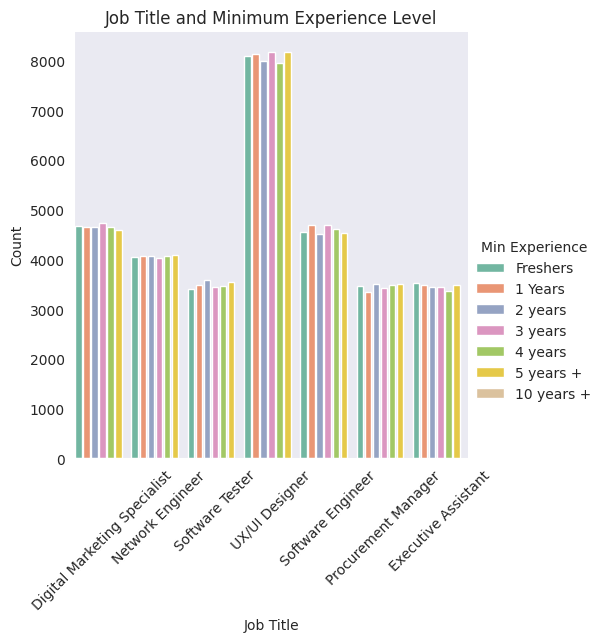

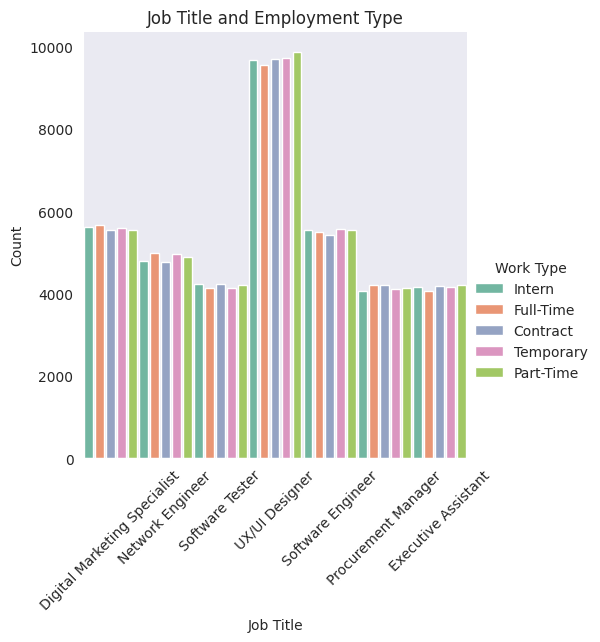

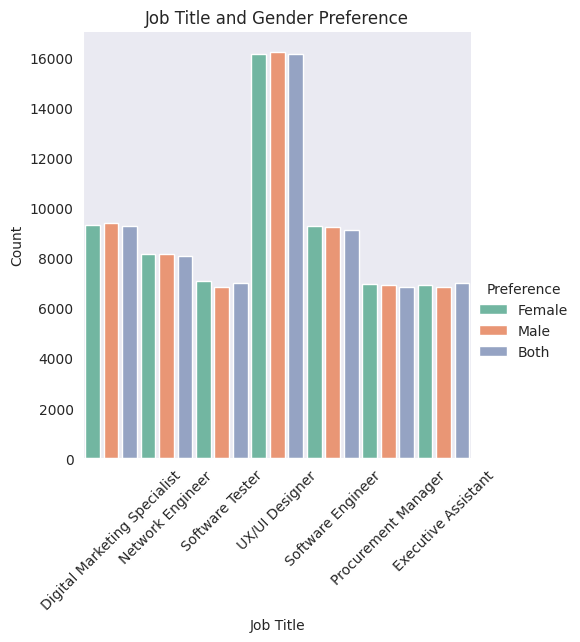

In [35]:
exp_order=['Freshers','1 Years','2 years', '3 years', '4 years', '5 years +', '10 years +']

my_catplot(variable='Min Experience', hue_order=exp_order , title='Job Title and Minimum Experience Level')

my_catplot(variable='Work Type', title='Job Title and Employment Type')

my_catplot(variable='Preference', title='Job Title and Gender Preference')

In [55]:
seven_country = df['Country'].value_counts().head(8)

seven_country_only = df[df['Country'].isin([i for i in seven_country.index])]

country_high_paid = seven_country_only[['Country', 'Min Salary']].groupby(by='Country').mean().sort_values(by='Min Salary', ascending=False)

country_high_paid

,Min Salary
Country,
Sierra Leone,60.039446
Azerbaijan,60.033887
Malta,60.012042
Sri Lanka,59.999346
San Marino,59.998429
Somalia,59.992587
"Venezuela, RB",59.947622
Vietnam,59.931364


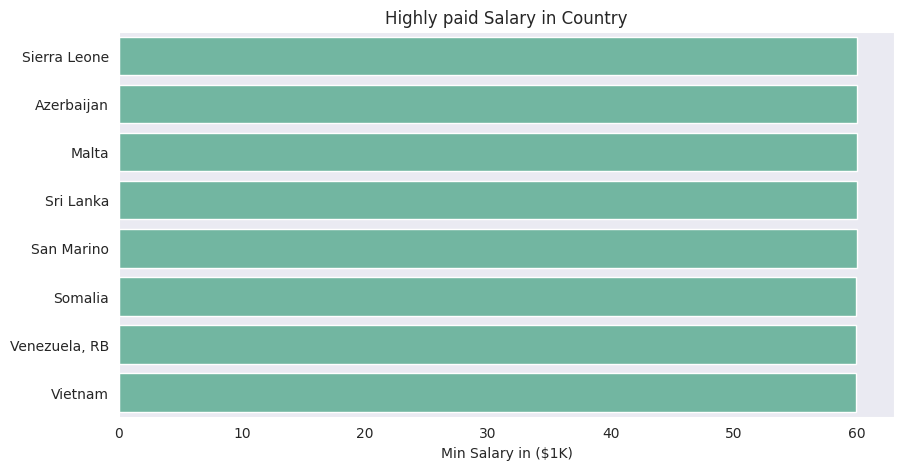

In [58]:
plt.figure(figsize=(10, 5))

sns.barplot(data=country_high_paid, y=country_high_paid.index, x='Min Salary')

plt.ylabel('')
plt.xlabel('Min Salary in ($1K)')
plt.title('Highly paid Salary in Country');

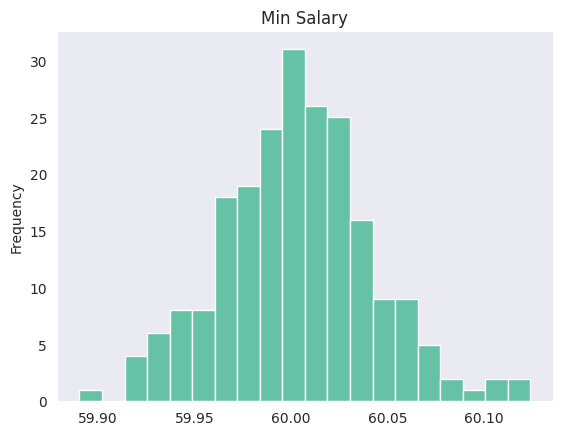

In [51]:
from matplotlib import pyplot as plt
country_high_paid['Min Salary'].plot(kind='hist', bins=20, title='Min Salary')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
sns.catplot(data=df,
            x='Min Experinece',
            y ='Min Salary',
            order=exp_order,
            height= 10,
            kind='box',
            hue='company_size')

plt.title('Experience Level, Salary, and Company Size')
plt.ylabel('Min Salary')
plt.xlabel('');

In [2]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define function to encode text with BERT and get embeddings
def get_bert_embeddings(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=128, padding='max_length', return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        embeddings = outputs[0][:, 0, :].numpy()  # Extract the embeddings from the [CLS] token
    return embeddings

# Load hiring database (example: job descriptions)
# data = pd.read_csv('Job Decription')  # Assuming your hiring database is stored in a CSV file

data = df

# Preprocess and encode job descriptions with BERT
job_embeddings = data['Job Description'].apply(get_bert_embeddings).values

# Define a candidate profile (example)
candidate_profile = "Experienced software engineer with a background in machine learning and data science."

# Preprocess and encode candidate profile with BERT
candidate_embedding = get_bert_embeddings(candidate_profile)

# Calculate cosine similarity between candidate profile and job descriptions
similarities = cosine_similarity(candidate_embedding.reshape(1, -1), job_embeddings)

# Get indices of top N most similar job descriptions
N = 5  # Number of recommendations
top_indices = similarities.argsort(axis=1)[0][-N:][::-1]

# Print recommended job descriptions
print("Top {} recommended job descriptions:".format(N))
for idx in top_indices:
    print("- Job Title: {}".format(data.iloc[idx]['job_title']))
    print("  Description: {}".format(data.iloc[idx]['job_description']))
    print("  Similarity Score: {:.2f}".format(similarities[0][idx]))
    print()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NameError: name 'df' is not defined

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define user context (example: user's past interactions or preferences)
user_context = "I enjoy reading science fiction novels and watching space documentaries."

# Tokenize user context
input_ids = tokenizer.encode(user_context, return_tensors="pt")

# Generate recommendations
output = model.generate(input_ids,
                         max_length=100,
                         num_return_sequences=2,
                         temperature=1.0,
                         top_k=50,
                         pad_token_id=tokenizer.eos_token_id,  # Set pad token ID to end-of-sequence token ID
                         attention_mask=torch.ones(input_ids.shape))  # Set attention mask to indicate all tokens are attended to

# Decode generated recommendations
recommendations = [tokenizer.decode(sequence, skip_special_tokens=True) for sequence in output]

# Print recommendations
print("Top Recommendations:")
for i, recommendation in enumerate(recommendations, start=1):
    print(f"{i}. {recommendation}")



ValueError: Greedy methods without beam search do not support `num_return_sequences` different than 1 (got 2).

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
import torch

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
config = GPT2Config.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)

# Define user context (example: user's past interactions or preferences)
user_context = "I enjoy reading science fiction novels and watching space documentaries."

# Tokenize user context
input_ids = tokenizer.encode(user_context, return_tensors="pt")

# Generate recommendations using beam search
output = model.generate(input_ids,
                         max_length=100,
                         num_return_sequences=5,
                         temperature=1.0,
                         top_k=50,
                         num_beams=5,  # Enable beam search with 5 beams
                         pad_token_id=tokenizer.eos_token_id,
                         early_stopping=True)

# Decode generated recommendations
recommendations = [tokenizer.decode(sequence, skip_special_tokens=True) for sequence in output]

# Print recommendations
print("Top Recommendations:")
for i, recommendation in enumerate(recommendations, start=1):
    print(f"{i}. {recommendation}")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Top Recommendations:
1. I enjoy reading science fiction novels and watching space documentaries. I'm also a huge fan of sci-fi and fantasy.

What is your favorite sci-fi novel?

My favorite sci-fi novel is The Last of Us. It's one of my favorite sci-fi novels of all time.

What is your favorite sci-fi novel of all time?

My favorite sci-fi novel is The Last of Us. It's one of my favorite sci-fi
2. I enjoy reading science fiction novels and watching space documentaries. I'm also a huge fan of sci-fi and fantasy.

What is your favorite sci-fi novel?

My favorite sci-fi novel is The Last of Us. It's one of my favorite sci-fi novels of all time.

What is your favorite sci-fi movie?

My favorite sci-fi movie is The Last of Us. It's one of my favorite sci-fi movies of all
3. I enjoy reading science fiction novels and watching space documentaries. I'm also a huge fan of sci-fi and fantasy.

What is your favorite sci-fi novel?

My favorite sci-fi novel is The Last of Us. It's one of my favorit

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

# Load dataset containing job descriptions and candidate profiles
# Replace this with your actual dataset loading code
dataset = df

# Tokenize all candidate profiles and job descriptions together
texts = list(dataset["Job Description"]) + [candidate_profile]
encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Generate embeddings for all texts
with torch.no_grad():
    outputs = model(**encoded_input)
embeddings = outputs.last_hidden_state

# Calculate similarity between candidate profile and job descriptions
candidate_embedding = embeddings[-1].unsqueeze(0)  # Candidate profile embedding
job_embeddings = embeddings[:-1]  # Job description embeddings
similarity_scores = cosine_similarity(candidate_embedding, job_embeddings)[0]

# Add similarity scores to the dataset
dataset["similarity_score"] = similarity_scores

# Sort jobs by similarity score in descending order
sorted_dataset = dataset.sort_values(by="similarity_score", ascending=False)

# Print top job recommendations
top_recommendations = sorted_dataset.head(10)
print(top_recommendations)


ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = df
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Summary statistics
print("\nSummary statistics of numerical columns:")
print(df.describe())

# Data types and missing values
print("\nData types and missing values:")
print(df.info())

# Distribution of job categories
plt.figure(figsize=(10, 6))
sns.countplot(x="job_category", data=df)
plt.title("Distribution of Job Categories")
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Word cloud of job titles
from wordcloud import WordCloud

job_titles_text = " ".join(df["job_title"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(job_titles_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Job Titles")
plt.axis("off")
plt.show()

# Distribution of job locations
plt.figure(figsize=(10, 6))
sns.countplot(x="job_location", data=df, order=df["job_location"].value_counts().index[:10])
plt.title("Top 10 Job Locations")
plt.xlabel("Job Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Distribution of required experience levels
plt.figure(figsize=(10, 6))
sns.countplot(x="experience_level", data=df, order=df["experience_level"].value_counts().index)
plt.title("Distribution of Required Experience Levels")
plt.xlabel("Experience Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


First few rows of the dataset:
             Job Id     Experience Qualifications Salary Range    location  \
0  1089843540111562  5 to 15 Years         M.Tech    $59K-$99K     Douglas   
1   398454096642776  2 to 12 Years            BCA   $56K-$116K    Ashgabat   
2   481640072963533  0 to 12 Years            PhD   $61K-$104K       Macao   
3   688192671473044  4 to 11 Years            PhD    $65K-$91K  Porto-Novo   
4   117057806156508  1 to 12 Years            MBA    $64K-$87K    Santiago   

            Country  latitude  longitude  Work Type  Company Size  ...  \
0       Isle of Man   54.2361    -4.5481     Intern         26801  ...   
1      Turkmenistan   38.9697    59.5563     Intern        100340  ...   
2  Macao SAR, China   22.1987   113.5439  Temporary         84525  ...   
3             Benin    9.3077     2.3158  Full-Time        129896  ...   
4             Chile  -35.6751   -71.5429     Intern         53944  ...   

                 Contact                     Job Title 

ValueError: Could not interpret value `job_category` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>